## Generate the QASM Dataset

In [2]:
import os
print(os.getcwd())


d:\course\thesis\Project2\QCD


In [3]:
from algorthims import *
from tqdm import tqdm

d:\programing\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\programing\Anaconda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\programing\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:


print(os.getcwd())

def QASM_generator(circuitname, max_qubit):
    # Create directory if it doesn't exist
    directory = "Circuits"
    if not os.path.exists(directory):
        os.makedirs(directory)

    try:
        # Retrieve the function by name from the global namespace
        circuit_func = globals()[circuitname]
        print(f"Function '{circuitname}' found.")
    except KeyError:
        print(f"Unsupported circuit name: {circuitname}")
        return

    for n in range(2, max_qubit + 1):
        circuit = circuit_func(n)
        qasm_str = circuit.qasm()
        filename = os.path.join(directory, f"{circuitname}_{n}.qasm")
        with open(filename, "w") as file:
            file.write(qasm_str)
        print(f"Saved {filename}")


d:\course\thesis\Project2\QCD


In [5]:
# QASM_generator('qft',20)
# QASM_generator('qpe',20)
# QASM_generator('grover',20)
# QASM_generator('h_c',40)
# QASM_generator('rx_c',40)
# QASM_generator('rx_gradually_c',40)
# QASM_generator('qft_decom',40)
# QASM_generator('ry_c',40)
# QASM_generator('ry_decomposed',40)
# QASM_generator('qpe_dec',30)
# QASM_generator('ry_decomposed',20)

## genetic programming


In [6]:
import os
from algorthims import *

print(os.getcwd())

def QASM_generator(circuitname, max_qubit):
    # Create directory if it doesn't exist
    directory = "Circuits"
    if not os.path.exists(directory):
        os.makedirs(directory)

    try:
        # Retrieve the function by name from the global namespace
        circuit_func = globals()[circuitname]
        print(f"Function '{circuitname}' found.")
    except KeyError:
        print(f"Unsupported circuit name: {circuitname}")
        return

    for n in range(2, max_qubit + 1):
        circuit = circuit_func(n)
        qasm_str = circuit.qasm()
        filename = os.path.join(directory, f"{circuitname}_{n}.qasm")
        with open(filename, "w") as file:
            file.write(qasm_str)
        print(f"Saved {filename}")

# Example usage:
# QASM_generator("h_0", 10)


d:\course\thesis\Project2\QCD


The basic idea of genetic programming is apply operations which similar to a natural genetic process to a certain task. During each time of a replication(or so-called off-spring), we randomly select some parameters from the parameter space and do some measurement on our selection. The evaluation of these observation is task-dependent. We select some of with the higher perforamnce and keep them to the next generation. we repeat such iteration turn by turns, keeps the highest or some of the highest scores species(the entity of the selection of the parameter sapce) to the  latter off-spring. in the context of circuit decomplier. For a certain quantum circuit $C_A^N$ (A, correspond to the underlying algorithm and N correspond the the scale of the quabit), we want to learn the underlying pattern for such quantum circuit or in other words, let our circyit Decomplier to "explain" the quantum circuit. So the evaluation of each iteration in our genetic programing is how close the circit generated by our decomplier to the ground truth, the actual circuit of the $C_A^N$.

Therefore, to implement the Decomplier using Genetic algorthim, we first just start from the simplest case. We regard every circuit $C_A^N$ can be composed of some combination of the "print" operation and the "For" loop
- For the print operation, the parameter space is composed with the typical syntax in QASM file, it include "Gate Definiation" "register" and "gate operators", to begin from the bottle, we start with[h,q ]

- For the for loop, we need to determine the number of loop we need, we can can struct it as 
```python
for i in range (1,n,1):


In [7]:
print(abs(random.gauss(0, 1)),int(random.gauss(0, 1)))


0.8137460994549084 0


### circuit generation

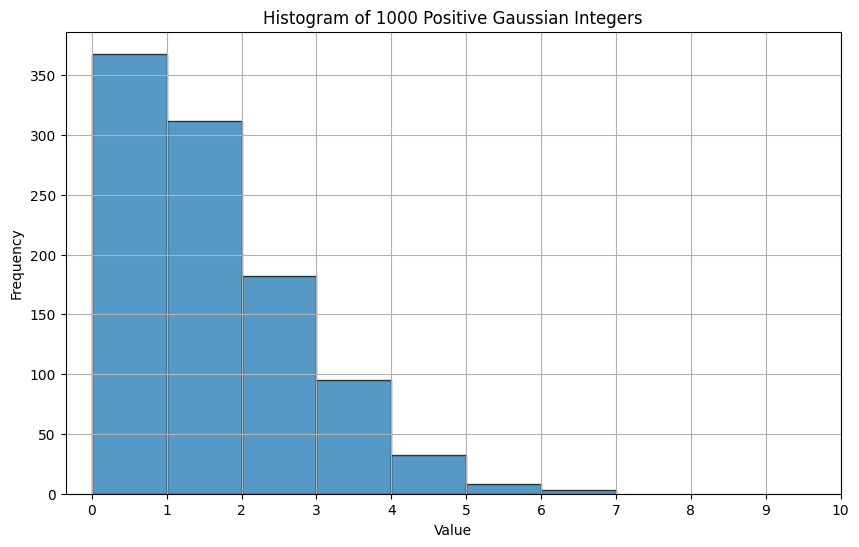

1


In [8]:
import random
import matplotlib.pyplot as plt
def random_positive_gaussian_integers(mu=0, sigma=1):
    """Generate positive random integers from a Gaussian distribution, ensuring all numbers are within a given range [1, upper_bound].
    
    Args:
        mu (float): Mean of the Gaussian distribution.
        sigma (float): Standard deviation of the Gaussian distribution.
        num_samples (int): Number of samples to generate.
        upper_bound (int): Maximum value of the random integer (inclusive).
    """
    # Generate number, take absolute value, round, and apply upper bound
    number = random.gauss(mu, sigma)
    positive_integer = int(abs(number))
    return positive_integer

data = []
for i in range (1000):\
    data.append(random_positive_gaussian_integers(mu=0, sigma=2))

plt.figure(figsize=(10, 6))
plt.hist(data, bins=range(0, max(data) + 2), edgecolor='black', alpha=0.75)
plt.title('Histogram of 1000 Positive Gaussian Integers')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(range(0, 11))  
plt.grid(True)
plt.show()
print(random_positive_gaussian_integers())

In [9]:
import ast
import random


def random_expr(depth, max_expr_operators, var_depth):
    """Generate a random qubit index expression using arithmetic, modulus, or simple variables.

    Args:
    depth (int): Number of loop variables.
    max_expr_operators (int): Number of binary operations to perform.
    var_depth (int): Number of additional variables.
    """
    # Generate variable names for loop indices and variables
    loop_vars = [f"i{ind}" for ind in range(depth)]
    vars = ['n']+[f"{ind}" for ind in range(var_depth+1)]

    # All possible variables include 'n' and loop indices
    choices = [ast.Name(id='n', ctx=ast.Load())] + \
              [ast.Name(id=var, ctx=ast.Load()) for var in loop_vars ]

    # Start with a random variable
    # expr = ast.Name(id=random.choice(vars),ctx=ast.Load())
    expr=random.choice(choices)
    # Add binary operations
    for _ in range(max_expr_operators+1):
        left = expr
        right = ast.Name(id=random.choice(vars),ctx=ast.Load())
        op = random.choice([ast.Add(), ast.Sub()])
        expr = ast.BinOp(left=left, op=op, right=right)
    return expr
    # Apply modulo operation to ensure the result is within valid index range
def random_qubit_expr(expr):
    mod_expr = ast.BinOp(left=expr, op=ast.Mod(), right=ast.Name(id='n', ctx=ast.Load()))

    return mod_expr

# Example of using the function
###  num_loops   num_operators  len_var

ast_node = random_expr(1, 2, 3)
print(ast.unparse(ast_node))
index=random_qubit_expr(ast_node)
print(ast.unparse(index))



i0 - 2 + 1 - 0
(i0 - 2 + 1 - 0) % n


In [10]:

def random_phase_expr(depth):
    """Generate a random phase expression of the form pi * 1 / (2^a + b + c)."""
    loop_vars = [f"i{ind}" for ind in range(depth)]
 
    # Define a
    a = random_expr(depth,depth,0)

    # Define b
    b = random_expr(depth,depth,0)
    # Define c
    c = ast.Constant(value=random_positive_gaussian_integers())
    
    # Create the expression 2^a + b + c
    expr_inner = ast.BinOp(
        left=ast.BinOp(
            left=ast.Constant(value=2),
            op=ast.Pow(),
            right=a
        ),
        op=ast.Add(),
        right=ast.BinOp(
            left=b,
            op=ast.Add(),
            right=c
        )
    )
    # Create the expression pi * 1 / (2^a + b + c)
    phase_expr = ast.BinOp(
        left=ast.Name(id='pi', ctx=ast.Load()),
        op=ast.Mult(),
        right=ast.BinOp(
            left=ast.Constant(value=1),
            op=ast.Div(),
            right=expr_inner
        )
    )
    sign = random.choice([1, -1])
    if sign == -1:
        phase_expr = ast.UnaryOp(op=ast.USub(), operand=phase_expr)
    return phase_expr
    
ast_phase=random_phase_expr(2)
print(ast.unparse(ast_phase))

pi * (1 / (2 ** (n - 0 + n + 0) + (i1 + 0 + 0 + 0 + 0)))


In [11]:
def loop_index(depth):
    if depth == 1:
        return ast.Name(id='n', ctx=ast.Load())
    else:
        # Generate variable names for loop indices
        vars = [f"i{ind}" for ind in range(depth-1)]
        choices = [ast.Name(id='n', ctx=ast.Load())]+\
        [ast.Name(id=var, ctx=ast.Load()) for var in vars]

        # Start with a random variable
        expr = random.choice(choices)

        # Add binary operations
        for _ in range(depth - 1):
            left = expr
            right = random.choice(choices)
            op = random.choice([ast.Add(), ast.Sub()])
            expr = ast.BinOp(left=left, op=op, right=right)

        # Random value to add/subtract
        value = random.randint(0, depth-1)  # Using a random integer instead of string
        index = ast.BinOp(left=expr, op=random.choice([ast.Add(), ast.Sub()]), 
                          right=ast.Constant(value=value))

        return ast.Call(
            func=ast.Name(id='abs', ctx=ast.Load()),
            args=[index],
            keywords=[])

# Create an example use of the function and unparse it
example_index = loop_index(2)
print(ast.unparse(example_index))



abs(i0 + i0 + 0)


In [12]:
# Define example operations and number of nodes
rotation_gates = ['rx', 'ry', 'rz', 'u1', 'u2', 'u3', 'crx', 'cry', 'crz', 'cp', 'cu1', 'cu3']
multi_qubit_gates = ['cx', 'cz', 'swap', 'ch', 'csx', 'cy', 'ccx', 'cswap', 'cu', 'cp']
three_qubit_gates = ['ccx', 'cswap']  # Toffoli (CCX) gate and Fredkin (CSWAP) gate


def find_gate_calls(node):
    """Recursively find all gate call nodes in the AST."""
    gate_calls = []
    
    if isinstance(node, ast.Call):
        gate_calls.append(node)
    
    for child in ast.iter_child_nodes(node):
        gate_calls.extend(find_gate_calls(child))
    
    return gate_calls
def find_parent_node(root, target_node):
    """Find the parent node of the target node in the AST."""
    for node in ast.walk(root):
        for child in ast.iter_child_nodes(node):
            if child is target_node:
                return node
    return None

def generate_gate_call(depth, gate):
    """Generate a gate call expression based on the gate type and depth."""
    expr = random_expr(depth,np.random.randint(0,depth+1),1)
    index = random_qubit_expr(expr)
    if gate in multi_qubit_gates:
        target_expr = random_expr(depth,np.random.randint(0,depth+1),1)
        target_qubit_index = random_qubit_expr(target_expr)
        if gate in rotation_gates:
            phase = random_phase_expr(depth)
            gate_call = ast.Expr(value=ast.Call(
                func=ast.Attribute(value=ast.Name(id="qc", ctx=ast.Load()), attr=gate, ctx=ast.Load()),
                args=[phase, index, target_qubit_index],
                keywords=[]
            ))
        else:
            gate_call = ast.Expr(value=ast.Call(
                func=ast.Attribute(value=ast.Name(id="qc", ctx=ast.Load()), attr=gate, ctx=ast.Load()),
                args=[index, target_qubit_index],
                keywords=[]
            ))
    else:
        if gate in rotation_gates:
            phase = random_phase_expr(depth)
            gate_call = ast.Expr(value=ast.Call(
                func=ast.Attribute(value=ast.Name(id="qc", ctx=ast.Load()), attr=gate, ctx=ast.Load()),
                args=[phase, index],
                keywords=[]
            ))
        else:
            gate_call = ast.Expr(value=ast.Call(
                func=ast.Attribute(value=ast.Name(id="qc", ctx=ast.Load()), attr=gate, ctx=ast.Load()),
                args=[index],
                keywords=[]
            ))
    return gate_call

code=generate_gate_call(1,'cp')
ast.unparse(code)

'qc.cp(pi * (1 / (2 ** (n - n + 0) + (n + n + 0 + 0))), (i0 + 0 - 0) % n, (i0 + 0 - 1) % n)'

In [13]:
def generate_random_circuit_ast(num_nodes, operations, max_loop_depth):
    args = ast.arguments(
        posonlyargs=[],
        args=[ast.arg(arg='n', annotation=None)],
        vararg=None,
        kwonlyargs=[],
        kw_defaults=[],
        kwarg=None,
        defaults=[]
    )

    body = [
        ast.Assign(
            targets=[ast.Name(id="qc", ctx=ast.Store())],
            value=ast.Call(
                func=ast.Name(id='QuantumCircuit', ctx=ast.Load()),
                args=[ast.Name(id='n', ctx=ast.Load())],
                keywords=[]
            )
        )
    ]

    for i in range(num_nodes):
        depth = 0
        gate = random.choice(operations)
        if random.choice([True, False]):  # Randomly decide to use a loop or a single operation
            loop_body = []
            loop_depth = random.randint(1, max_loop_depth)
            loop_vars = [f"i{ind}" for ind in range(loop_depth)]
            current_body = loop_body
            for j in range(loop_depth):
                depth += 1
                loop = ast.For(
                    target=ast.Name(id=loop_vars[depth-1], ctx=ast.Store()),
                    iter=ast.Call(func=ast.Name(id='range', ctx=ast.Load()), args=[loop_index(depth)], keywords=[]),
                    body=[],
                    orelse=[]
                )
                current_body.append(loop)
                current_body = loop.body

                # Decide to add a gate call in the loop body
                add_gate=random.randint(0,2)
                for i in range(add_gate):
                    gate_call = generate_gate_call(depth, gate)
                    current_body.append(gate_call)

            choices = [ast.Name(id='n', ctx=ast.Load())] + [ast.Name(id=var, ctx=ast.Load()) for var in loop_vars]
            qubit_index = random.choice(choices)
            gate_call = generate_gate_call(depth, gate)
            current_body.append(gate_call)
            body.extend(loop_body)
        else:
            gate_call = generate_gate_call(depth, gate)
            body.append(gate_call)

    body.append(ast.Return(value=ast.Name(id="qc", ctx=ast.Load())))

    function_def = ast.FunctionDef(
        name="generate_random_circuit_ast",
        args=args,
        body=body,
        decorator_list=[],
        returns=None,
        type_comment=None
    )

    module = ast.Module(body=[function_def], type_ignores=[])
    ast.fix_missing_locations(module)
    return module

# Example usage
operations = rotation_gates + multi_qubit_gates + three_qubit_gates  # List of gates to use
random_circuit = generate_random_circuit_ast(4, operations, 3)
print(ast.unparse(random_circuit))

def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    for i0 in range(n):
        qc.u1(-(pi * (1 / (2 ** (i0 + n - n) + (n - 0 + 0 + 0)))), (i0 - 1 - 1) % n)
        qc.u1(-(pi * (1 / (2 ** (i0 - 0 + n) + (i0 + 0 - n + 0)))), (n + n - 1) % n)
        for i1 in range(abs(i0 + i0 + 1)):
            for i2 in range(abs(i1 + i0 - i0 - 1)):
                qc.u1(-(pi * (1 / (2 ** (n + n - n + n - n) + (i0 - n - n + n + 0 + 1)))), (i0 + n + 1 + n + n) % n)
    qc.cx((n - n) % n, (n - n) % n)
    qc.u3(pi * (1 / (2 ** (n - n) + (n - 0 + 0))), (n + 0) % n)
    for i0 in range(n):
        for i1 in range(abs(n - i0 - 1)):
            qc.ccx((n + n + 1) % n, (n - 1) % n)
            qc.ccx((i1 - 0) % n, (i0 + 1) % n)
            qc.ccx((i1 - 1) % n, (i0 + n) % n)
    return qc


### genetic decomplier

In [14]:
def analyze_ast(node, output=False):
    gate_calls = []
    qc_calls = []
    parent_info = []
    index_depths = []

    def visit_node(node, depth=0):
        if isinstance(node, ast.Call) and isinstance(node.func, ast.Attribute) and isinstance(node.func.value, ast.Name) and node.func.value.id == 'qc':
            qc_calls.append(node)
            index_depth = 0
            args = [ast.unparse(arg) for arg in node.args]
            if output:
                print(f"{'  ' * depth}Found qc call: {ast.dump(node)} at depth {depth}")
                print(f"{'  ' * depth}Arguments: {args}")
            for arg in node.args:
                arg_str = ast.unparse(arg)
                if 'pi' in arg_str:
                    continue
                # Check for 'i' and find the maximum number following 'i'
                for part in arg_str.split():
                    if 'i' in part:
                        i_pos = part.find('i')
                        if i_pos != -1 and i_pos < len(part) - 1:
                            num_str = ''.join(filter(str.isdigit, part[i_pos+1:]))
                            if num_str:
                                index_depth = max(index_depth, int(num_str) + 1)
            index_depths.append(index_depth)
            if output:
                print(f"{'  ' * depth}Index Depth: {index_depth}\n")
        for child in ast.iter_child_nodes(node):
            visit_node(child, depth + 1)

    visit_node(node)
    return gate_calls, qc_calls, parent_info, index_depths


In [15]:
from copy import deepcopy
import os
import shutil
import importlib.util
from qiskit.circuit.exceptions import CircuitError
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.quantum_info import Operator, state_fidelity,process_fidelity
import Levenshtein
import time
from tqdm import tqdm
rotation_gates = ['rx', 'ry', 'rz', 'u1', 'u2', 'u3', 'crx', 'cry', 'crz', 'cp', 'cu1', 'cu3']
multi_qubit_gates = ['cx', 'cz', 'swap', 'ch', 'csx', 'cy', 'ccx', 'cswap', 'cu', 'cp']
three_qubit_gates = ['ccx', 'cswap']  # Toffoli (CCX) gate and Fredkin (CSWAP) gate

class genetic_Decompiler:
    def __init__(self, algorithm_name, qubit_limit=20, generations=100, pop_size=50, max_length=10, 
                 perform_crossover=True,crossover_rate=0.3, new_gen_rate=0.2,mutation_rate=0.1,
                 compare_method='l_by_l',max_loop_depth=2, mutation_rate_2=0.5, perform_annealing=False,
                perform_mutation=True, selection_method='tournament',operations = ['h', 'x', 'cx']):
        self.algorithm_name = algorithm_name
        self.qubit_limit = qubit_limit
        self.generations = generations
        self.pop_size = pop_size
        self.max_length = max_length
        self.crossover_rate=crossover_rate
        self.mutation_rate=mutation_rate
        self.mutation_rate_2 = mutation_rate_2
        self.new_gen_rate=new_gen_rate
        self.max_loop_depth=max_loop_depth
        self.perform_crossover = perform_crossover
        self.compare_method=compare_method
        self.perform_annealing = perform_annealing
        self.perform_mutation = perform_mutation
        self.selection_method = selection_method
        self.operations=operations
        # Initialize the path for saving files related to the algorithm
        self.path = os.path.join('genetic_deQ', self.algorithm_name)
        self.qasm_path=os.path.join('genetic_deQ_qasm', self.algorithm_name)
        os.makedirs(self.path, exist_ok=True)  # Create the directory if it does not exist
        os.makedirs(self.qasm_path, exist_ok=True) 
 

    def generate_initial_population(self,size):
        population = []
        for _ in range(size):
            # num_qubits = random.randint(2, self.qubit_limit)
            num_nodes = random.randint(1, self.max_length)
            ast_circuit = generate_random_circuit_ast( num_nodes,self.operations,max_loop_depth=self.max_loop_depth)
            population.append(ast_circuit)
        return population

    
    def mutate(self, ast_circuit, mutation_rate_2=0.5, output=False):
        mutation_rate_2 = self.mutation_rate_2
        # Create a deep copy of the AST to avoid modifying the original AST
        ast_circuit_copy = deepcopy(ast_circuit)

        # Analyze the AST
        gate_calls, qc_calls, parent_info, index_depths = analyze_ast(ast_circuit_copy, output=False)

        if not qc_calls:
            return ast_circuit_copy  # No gate calls to mutate

        # Randomly choose mutation type
        mutation_type = random.choices(['insert', 'modify'], weights=[0.2, 0.8])[0]

        if mutation_type == 'insert':
            # Randomly select a parent node to insert into
            if not parent_info:
                return ast_circuit_copy  # No parent nodes to insert into

            parent_node, parent_index = random.choice(parent_info)
            new_gate = generate_gate_call(random.choice(self.operations))
            parent_node.body.insert(parent_index, new_gate)
            if output:
                print(f"Inserted new gate: {ast.unparse(new_gate)} at index {parent_index}")

        elif mutation_type == 'modify':
            # Randomly select a qc call to mutate with a probability
            for qc_call, index_depth in zip(qc_calls, index_depths):
                if random.random() < mutation_rate_2:
                    if output:
                        original_code = ast.unparse(qc_call)

                    # Extract arguments and classify them
                    for i, arg in enumerate(qc_call.args):
                        arg_str = ast.unparse(arg)
                        if 'pi' in arg_str:
                            # Mutate phase argument
                            qc_call.args[i] = random_phase_expr(index_depth)
                        else:
                            # Mutate index argument
                            new_expr = random_expr(index_depth, 3, 1)
                            qc_call.args[i] = random_qubit_expr(new_expr)

                    if output:
                        new_code = ast.unparse(qc_call)
                        print(f"Modified code from: {original_code} to: {new_code}")

        ast.fix_missing_locations(ast_circuit_copy)
        return ast_circuit_copy

    def crossover(self, parent1, parent2):
        # Select crossover points
        index1 = random.randint(1, len(parent1.body[0].body) - 2)
        index2 = random.randint(1, len(parent2.body[0].body) - 2)
        
        # Swap subcircuits
        new_body1 = parent1.body[0].body[:index1] + parent2.body[0].body[index2:]
        new_body2 = parent2.body[0].body[:index2] + parent1.body[0].body[index1:]
        
        # Construct new ASTs
        child1 = ast.Module(body=[ast.FunctionDef(
            name=parent1.body[0].name, 
            args=parent1.body[0].args, 
            body=new_body1, 
            decorator_list=[]
        )], type_ignores=[])
        
        child2 = ast.Module(body=[ast.FunctionDef(
            name=parent2.body[0].name, 
            args=parent2.body[0].args, 
            body=new_body2, 
            decorator_list=[]
        )], type_ignores=[])
        
        ast.fix_missing_locations(child1)
        ast.fix_missing_locations(child2)
        
        return child1, child2

    def select_parents(self, population, fitness_scores, selection_method='tournament', k=3):
        if selection_method == 'roulette':
            return self.roulette_wheel_selection(population, fitness_scores)
        elif selection_method == 'tournament':
            return self.tournament_selection(population, fitness_scores, k)
        elif selection_method == 'rank':
            return self.rank_selection(population, fitness_scores)
        elif selection_method == 'random':
            return self.random_selection(population)
        elif selection_method == 'weighted_roulette':
            return self.weighted_roulette_wheel_selection(population, fitness_scores)
        else:
            raise ValueError(f"Unknown selection method: {selection_method}")
    
    def roulette_wheel_selection(self, population, fitness_scores):
        total_fitness = sum(fitness_scores)
        probabilities = [score / total_fitness for score in fitness_scores]
        selected_indices = random.choices(range(len(population)), weights=probabilities, k=2)
        return population[selected_indices[0]], population[selected_indices[1]]

    def tournament_selection(self, population, fitness_scores, k=3):
        selected_indices = random.sample(range(len(population)), k)
        selected_individuals = [(fitness_scores[i], population[i]) for i in selected_indices]
        parent1 = max(selected_individuals, key=lambda x: x[0])[1]
        parent2 = max(selected_individuals, key=lambda x: x[0])[1]
        return parent1, parent2

    def rank_selection(self, population, fitness_scores):
        sorted_population = sorted(zip(fitness_scores, population), key=lambda x: x[0])
        rank_probabilities = [(i + 1) / len(sorted_population) for i in range(len(sorted_population))]
        selected_indices = random.choices(range(len(population)), weights=rank_probabilities, k=2)
        return sorted_population[selected_indices[0]][1], sorted_population[selected_indices[1]][1]

    def random_selection(self, population):
        parent1, parent2 = random.sample(population, 2)
        return parent1, parent2

    def weighted_roulette_wheel_selection(self, population, fitness_scores, weight=2.0):
        total_fitness = sum(fitness_scores)
        weighted_fitness = [score ** weight for score in fitness_scores]
        total_weighted_fitness = sum(weighted_fitness)
        probabilities = [wf / total_weighted_fitness for wf in weighted_fitness]
        selected_indices = random.choices(range(len(population)), weights=probabilities, k=2)
        return population[selected_indices[0]], population[selected_indices[1]]

    def save(self, population):
    # Clear all files in the target directory before saving new files
        for filename in os.listdir(self.path):
            file_path = os.path.join(self.path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove file
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove directory
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

        # Iterate over the population and save each individual's Python code to a file
        for index, individual in enumerate(population):
            # Convert AST to Python code
            python_code = ast.unparse(individual)

            # Create the filename, including the algorithm name and index
            filename = os.path.join(self.path, f"{self.algorithm_name}_{index}.py")
            
            # Write Python code to the file
            with open(filename, 'w') as file:
                file.write(python_code)

    def get_quantum_gates_from_qasm(self):
        target_qasm_dir = "Circuits"
        all_gates = set()

        for i in range(2, self.qubit_limit + 1):
            target_qasm_file = os.path.join(target_qasm_dir, f"{self.algorithm_name}_{i}.qasm")
            
            if os.path.exists(target_qasm_file):
                with open(target_qasm_file, 'r') as file:
                    qasm_str = file.read()
                
                quantum_circuit = QuantumCircuit.from_qasm_str(qasm_str)
                
                for instruction in quantum_circuit.data:
                    gate_name = instruction[0].name
                    all_gates.add(gate_name)
        
        return list(all_gates)

    def save_qasm(self):
        for filename in os.listdir(self.path):
            if filename.endswith('.py'):
                full_py_path = os.path.join(self.path, filename)
                
                # Read and modify the script as discussed above
                with open(full_py_path, 'r') as file:
                    module_code = "from qiskit import QuantumCircuit\nimport numpy as np\nimport random\nfrom math import pi\n" + file.read()

                local_namespace = {}
                exec(module_code, local_namespace)
                
                # Set up the directory for QASM files
                file_base_name = filename[:-3]  # Remove '.py' extension
                qasm_dir_path = os.path.join(self.qasm_path, file_base_name)
                os.makedirs(qasm_dir_path, exist_ok=True)
                
                # Generate QASM files for each qubit count
                for i in range(2, self.qubit_limit + 1):
                    try:
                            # Print the generated Python code for debugging
                        # generated_code = module_code + f"\n\ngenerate_random_circuit_ast({i})"
                        # print(f"Running generated code for {file_base_name} with {i} qubits:\n{generated_code}")


                        qc = local_namespace['generate_random_circuit_ast'](i)

                        modified_circuit = QuantumCircuit(qc.num_qubits)
                        for gate, qargs, cargs in qc.data:
                            if gate.name == 'cx':
                                control_qubit, target_qubit = qargs
                                if control_qubit.index == target_qubit.index:
                                    # Adjust target qubit index to be different from control qubit index
                                    target_qubit = qc.qubits[(target_qubit.index + 1) % qc.num_qubits]
                                    modified_circuit.cx(control_qubit, target_qubit)
                                else:
                                    modified_circuit.cx(control_qubit, target_qubit)
                            else:
                                modified_circuit.append(gate, qargs, cargs)
                        
                        qasm_output = modified_circuit.qasm()
                    except (CircuitError, ZeroDivisionError) as e:
                    # Handle both CircuitError and ZeroDivisionError
                    # print(f"Error generating QASM for {filename} with {i} qubits: {e}")
                        qasm_output = ""  # Save an empty QASM file if there's an error
                    
                    qasm_filename = os.path.join(qasm_dir_path, f"{file_base_name}_{i}.qasm")
                    with open(qasm_filename, 'w') as f:
                        f.write(qasm_output)

    
    def qasm_to_unitary(self, qasm_file_path):
        # Read QASM file and create a quantum circuit
        with open(qasm_file_path, 'r') as file:
            qasm_str = file.read()
        
        quantum_circuit = QuantumCircuit.from_qasm_str(qasm_str)
        
        # Use Aer simulator to get the unitary matrix
        backend = Aer.get_backend('unitary_simulator')
        transpiled_circuit = transpile(quantum_circuit, backend)
        
        # Get the unitary matrix
        job = backend.run(transpiled_circuit)
        unitary_matrix = job.result().get_unitary(transpiled_circuit)
        
        return unitary_matrix

    def qasm_to_gate_sequence(self, qasm_file_path):
        # Read QASM file and create a quantum circuit
        with open(qasm_file_path, 'r') as file:
            qasm_str = file.read()
        
        quantum_circuit = QuantumCircuit.from_qasm_str(qasm_str)
        
        # Extract gate sequence
        gate_sequence = []
        for instruction in quantum_circuit.data:
            gate_name = instruction[0].name
            qubits = [qubit.index for qubit in instruction[1]]
            if gate_name in rotation_gates:
                params = [param for param in instruction[0].params]
                gate_sequence.append((gate_name, tuple(qubits), params))
            else:
                gate_sequence.append((gate_name, tuple(qubits)))
        
        return gate_sequence
      
    def gate_sequence_similarity(self, seq1, seq2):
        seq1_str = ' '.join([f"{gate[0]}{gate[1]}{[f'{param:.6f}' for param in gate[2]]}" if len(gate) == 3 else f"{gate[0]}{gate[1]}" for gate in seq1])
        seq2_str = ' '.join([f"{gate[0]}{gate[1]}{[f'{param:.6f}' for param in gate[2]]}" if len(gate) == 3 else f"{gate[0]}{gate[1]}" for gate in seq2])
        
        ### Debugging line
        # print(f"Sequence 1: {seq1_str}")
        # print(f"Sequence 2: {seq2_str}")
        
        max_len = max(len(seq1_str), len(seq2_str))
        if max_len == 0:
            return 1.0
        
        return 1 - (Levenshtein.distance(seq1_str, seq2_str) / max_len)**(1/2)

    def gate_frequency_similarity(self, qasm_file_path1, qasm_file_path2):
        def get_gate_frequencies(qasm_file_path):
            with open(qasm_file_path, 'r') as file:
                qasm_str = file.read()
            
            quantum_circuit = QuantumCircuit.from_qasm_str(qasm_str)
            gate_count = {}
            for instruction in quantum_circuit.data:
                gate_name = instruction[0].name
                if gate_name in gate_count:
                    gate_count[gate_name] += 1
                else:
                    gate_count[gate_name] = 1
            return gate_count

        freq1 = get_gate_frequencies(qasm_file_path1)
        freq2 = get_gate_frequencies(qasm_file_path2)
        
        all_gates = set(freq1.keys()).union(set(freq2.keys()))
        # Check if the gate types are the same
        if set(freq1.keys()) != set(freq2.keys()):
            return 0.0  # Directly return 0 if the gate types are different
        vec1 = [freq1.get(gate, 0) for gate in all_gates]
        vec2 = [freq2.get(gate, 0) for gate in all_gates]
        
        dot_product = sum([vec1[i] * vec2[i] for i in range(len(all_gates))])
        norm1 = sum([x ** 2 for x in vec1]) ** 0.5
        norm2 = sum([x ** 2 for x in vec2]) ** 0.5
        
        return dot_product / (norm1 * norm2)

    def compare_qasm_lcs(self,qasm_lines, target_qasm_lines):
        def lcs_length(X, Y):
            m = len(X)
            n = len(Y)
            L = [[0] * (n + 1) for i in range(m + 1)]

            for i in range(m + 1):
                for j in range(n + 1):
                    if i == 0 or j == 0:
                        L[i][j] = 0
                    elif X[i - 1].strip() == Y[j - 1].strip():
                        L[i][j] = L[i - 1][j - 1] + 1
                    else:
                        L[i][j] = max(L[i - 1][j], L[i][j - 1])

            return L[m][n]
        # Calculate the length of the longest common subsequence
        lcs_len = lcs_length(qasm_lines, target_qasm_lines)
        
        # Calculate similarity score based on the length of LCS over the total lines in target_qasm
        score = lcs_len / len(target_qasm_lines) if target_qasm_lines else 0
        return score

    def compare_qasm(self, qasm, target_qasm):
        def is_file_empty(file_path):
            return os.path.getsize(file_path) == 0

        if is_file_empty(qasm) or is_file_empty(target_qasm):
            return 0
        try:
            if self.compare_method == 'fidelity':
                # Calculate unitary matrices for both QASM files
                unitary1 = self.qasm_to_unitary(qasm)
                unitary2 = self.qasm_to_unitary(target_qasm)
                
                # Calculate fidelity
                fidelity_score = process_fidelity(unitary1,unitary2)
                return fidelity_score

            elif self.compare_method == 'seq_similarity':
                # Gate sequence similarity
                seq1 = self.qasm_to_gate_sequence(qasm)
                seq2 = self.qasm_to_gate_sequence(target_qasm)
                seq_similarity = self.gate_sequence_similarity(seq1, seq2)
                return seq_similarity

            elif self.compare_method == 'freq_similarity':
                # Gate frequency similarity
                freq_similarity = self.gate_frequency_similarity(qasm, target_qasm)
                return freq_similarity


            elif self.compare_method == 'l_by_l':
                with open(qasm, 'r') as file1, open(target_qasm, 'r') as file2:
                    qasm_lines = file1.readlines()
                    target_qasm_lines = file2.readlines()
                    
                    score = self.compare_qasm_lcs(qasm_lines,target_qasm_lines)
                
                return score

            elif self.compare_method == 'combined':
                # Gate sequence similarity
                seq1 = self.qasm_to_gate_sequence(qasm)
                seq2 = self.qasm_to_gate_sequence(target_qasm)
                seq_similarity = self.gate_sequence_similarity(seq1, seq2)
                
                # Gate frequency similarity
                freq_similarity = self.gate_frequency_similarity(qasm, target_qasm)
                
                with open(qasm, 'r') as file1, open(target_qasm, 'r') as file2:
                    qasm_lines = file1.readlines()
                    target_qasm_lines = file2.readlines()
                    
                    lcs_similarity = self.compare_qasm_lcs(qasm_lines,target_qasm_lines)
                
                # combined_score = (seq_similarity + freq_similarity + inter_section_score) / 3
                combined_score = (seq_similarity * freq_similarity * lcs_similarity)**(1/3)
                return combined_score


        except FileNotFoundError:
            print(f"Error: One of the files not found ({qasm} or {target_qasm}).")
            return 0
        except Exception as e:
            print(f"Error comparing QASM files: {str(e)}")
            return 0   

    def evaluate(self, individual, individual_index):
        qasm_dir = os.path.join(self.qasm_path, f"{self.algorithm_name}_{individual_index}")
        target_qasm_dir = "Circuits"
        
        # Calculate score for each QASM file
        scores = []
        for i in range(2, self.qubit_limit+1):
            qasm_file = os.path.join(qasm_dir, f"{self.algorithm_name}_{individual_index}_{i}.qasm")
            target_qasm_file = os.path.join(target_qasm_dir, f"{self.algorithm_name}_{i}.qasm")
             ## debug
            # print(qasm_file,target_qasm_file)
            score = self.compare_qasm(qasm_file, target_qasm_file)
            scores.append(score)
        
        # Return the average score
        
        average_score = sum(scores) / len(scores) if scores else 0
        return average_score
            

    def run(self):
        if not self.perform_crossover and not self.perform_mutation:
            print("Warning: Both crossover and mutation are disabled; the population will not evolve.")

        best_score = float('-inf')
        best_individual = None
        best_generation_index = -1

        # Initialize lists to store scores
        best_scores = []
        all_scores = []
        best_code=[]

        # Generate initial population once at the beginning
        population = self.generate_initial_population(self.pop_size)

        for generation in range(self.generations):
            start_time = time.time()

            # Save the current population state and QASM data
            self.save(population)
            self.save_qasm()

            # Evaluate fitness for each individual
            fitness_scores = [self.evaluate(individual, index) for index, individual in enumerate(population)]

            # Save all fitness scores for this generation
            all_scores.append(fitness_scores)

            # Sort population by fitness (descending order)
            sorted_population = sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)
            sorted_scores, next_generation = zip(*sorted_population)
            next_generation = list(next_generation)
            sorted_scores = list(sorted_scores)

            # Select the best individual and corresponding score
            best_individual = next_generation[0]
            best_score = sorted_scores[0]
            
            # Save the best score for this generation
            best_scores.append(best_score)

            # Find the index of the best individual in the original population
            best_individual_index = fitness_scores.index(best_score)
            
            # Print debugging information
            # print(f"Algorithm : {self.algorithm_name}  Generation {generation + 1}: Best score = {best_score}")

            # # If the best score is 1, stop the iteration
            # if best_score == 1:
            #     break
            new_population = []

            # Number of individuals to be generated by each method
            crossover_count = int(self.pop_size * self.crossover_rate) if self.perform_crossover == True else 0
            mutation_count = int(self.pop_size * self.mutation_rate) if self.perform_mutation == True else 0
            new_gen_count = int(self.pop_size * self.new_gen_rate)
            elite_count = self.pop_size - crossover_count - mutation_count - new_gen_count

            # Preserve elite individuals
            new_population.extend(next_generation[:elite_count])

            # Apply crossover to generate new individuals
            while len(new_population) < elite_count + crossover_count:
                parent1, parent2 = self.select_parents(next_generation, sorted_scores, self.selection_method)
                
                child1, child2 = self.crossover(parent1, parent2)
            
                new_population.extend([child1, child2])

            # Apply mutation to new individuals
            for _ in range(mutation_count):
                if new_population:
                    individual_to_mutate = random.choice(new_population)
                    new_population.append(self.mutate(individual_to_mutate))
            
            # Generate new individuals
            new_population.extend(self.generate_initial_population(new_gen_count))
            individual_code = ast.unparse(best_individual) if best_individual else "No best individual found"
        
            best_code.append(individual_code)

            # Ensure the population size is correct after all operations
            # new_population = new_population[:self.pop_size]

            population = new_population

            # Apply annealing to the mutation_rate_2
            if self.perform_annealing:
                self.mutation_rate_2 = max(self.mutation_rate_2 * 0.99, 0.1)

            end_time = time.time()
            time_taken = end_time - start_time
            tqdm.write(f"Generation {generation + 1}/{self.generations} completed in {time_taken:.2f} seconds")

        # Unparse the AST of the best individual if found
        
        return best_code, best_scores, all_scores
   

In [16]:
(1*2*3)**(1/3)

1.8171205928321397

In [17]:
1.8171205928321397 ** 3

6.0

#### Test on crossover

In [18]:
operations=['h','x','cx','cp']
circuit_ast1 = generate_random_circuit_ast(2, operations,max_loop_depth=1)
code = ast.unparse(circuit_ast1)
print(code)
circuit_ast2 = generate_random_circuit_ast(2, operations,max_loop_depth=1)
code = ast.unparse(circuit_ast2)
print(code)
decompiler = genetic_Decompiler(operations=operations,generations=50,algorithm_name='h_c',qubit_limit=20,
                                perform_crossover=True,perform_mutation=False,)

                
child1, child2 = decompiler.crossover(circuit_ast1, circuit_ast2)
code=ast.unparse(child1)
print(code)
code=ast.unparse(child2)
print(code)


def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.h((n - n) % n)
    qc.cp(-(pi * (1 / (2 ** (n + 0) + (n - n + 0)))), (n + 0) % n, (n - 1) % n)
    return qc
def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.h((n - n) % n)
    qc.cp(-(pi * (1 / (2 ** (n - n) + (n + 0 + 0)))), (n + 0) % n, (n + 0) % n)
    return qc
def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.h((n - n) % n)
    qc.cp(-(pi * (1 / (2 ** (n - n) + (n + 0 + 0)))), (n + 0) % n, (n + 0) % n)
    return qc
def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.h((n - n) % n)
    qc.cp(-(pi * (1 / (2 ** (n + 0) + (n - n + 0)))), (n + 0) % n, (n - 1) % n)
    return qc


#### Test on Mutate

In [19]:
def analyze_ast(node, output=False):
    gate_calls = []
    qc_calls = []
    parent_info = []
    index_depths = []

    def visit_node(node, depth=0):
        if isinstance(node, ast.Call) and isinstance(node.func, ast.Attribute) and isinstance(node.func.value, ast.Name) and node.func.value.id == 'qc':
            qc_calls.append(node)
            index_depth = 0
            args = [ast.unparse(arg) for arg in node.args]
            if output:
                print(f"{'  ' * depth}Found qc call: {ast.dump(node)} at depth {depth}")
                print(f"{'  ' * depth}Arguments: {args}")
            for arg in node.args:
                arg_str = ast.unparse(arg)
                if 'pi' in arg_str:
                    continue
                # Check for 'i' and find the maximum number following 'i'
                for part in arg_str.split():
                    if 'i' in part:
                        i_pos = part.find('i')
                        if i_pos != -1 and i_pos < len(part) - 1:
                            num_str = ''.join(filter(str.isdigit, part[i_pos+1:]))
                            if num_str:
                                index_depth = max(index_depth, int(num_str) + 1)
            index_depths.append(index_depth)
            if output:
                print(f"{'  ' * depth}Index Depth: {index_depth}\n")
        for child in ast.iter_child_nodes(node):
            visit_node(child, depth + 1)

    visit_node(node)
    return gate_calls, qc_calls, parent_info, index_depths


In [21]:
# Example usage
operations = ['cx', 'cp', 'rx']  # List of gates to use
circuit_ast1 = generate_random_circuit_ast(2, operations, 1)
code = ast.unparse(circuit_ast1)
print("Original AST code:")
print(code)

Original AST code:
def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.cx((n + 1) % n, (n + 1) % n)
    qc.cp(-(pi * (1 / (2 ** (n - n) + (n - n + 0)))), (n + 0) % n, (n + 0) % n)
    return qc


In [42]:
decompiler = genetic_Decompiler(algorithm_name='ry')
new_child = decompiler.mutate(ast_circuit=circuit_ast1,output=True)
new_code = ast.unparse(new_child)
print("\nMutated AST code:")
print(new_code)

Modified code from: qc.cx((n + 1) % n, (n + 1) % n) to: qc.cx((n + n - 0 + 1 + 0) % n, (n - 1 + 0 + 0 + 0) % n)

Mutated AST code:
def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.cx((n + n - 0 + 1 + 0) % n, (n - 1 + 0 + 0 + 0) % n)
    qc.cp(-(pi * (1 / (2 ** (n - n) + (n - n + 0)))), (n + 0) % n, (n + 0) % n)
    return qc


In [21]:
gate_calls, qc_calls, parent_info, index_depth = analyze_ast(circuit_ast1,)

In [22]:
index_depth

[1, 1, 1, 0]

#### Decompliation

In [72]:

# To execute the genetic algorithm:
decompiler = genetic_Decompiler(operations=['h', 'x', 'rx', 'swap','cp'],qubit_limit=10,
                                generations=5,algorithm_name='h_0',compare_method='combined',max_loop_depth=2,
                                perform_crossover=True,perform_mutation=True,pop_size=30,perform_annealing=True,
                                new_gen_rate=0.2,crossover_rate=0.2,mutation_rate=0.4,max_length=10)
operations=decompiler.get_quantum_gates_from_qasm()
decompiler.operations=operations
best_code, best_score, all_scores = decompiler.run()
print(best_code[-1], '\n', best_score, '\n',all_scores)

C:\Users\86991\AppData\Local\Temp\ipykernel_9888\2414506021.py:299: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits = [qubit.index for qubit in instruction[1]]


Generation 1/5 completed in 3.62 seconds
Generation 2/5 completed in 2.28 seconds
Generation 3/5 completed in 2.35 seconds
Generation 4/5 completed in 2.16 seconds
Generation 5/5 completed in 2.03 seconds
def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.h((n - 1) % n)
    for i0 in range(n):
        qc.h((n - n) % n)
    qc.h((n + 1) % n)
    return qc 
 [0.7735651217075499, 0.7735651217075499, 0.7735651217075499, 0.7735651217075499, 0.7735651217075499] 
 [[0.2822463016047405, 0.2764582299329154, 0.4805459904465027, 0.31207319744276146, 0.669348042626402, 0.24451881437414316, 0.5255095022185323, 0.4033772409508105, 0.18970746259584584, 0.5585999753636801, 0.5679572816778808, 0.36043272265900317, 0.21310412271639032, 0.2265943775791338, 0.4973292801607641, 0.49761479997964053, 0.23872779261725002, 0.28436998544985825, 0.7735651217075499, 0.6185269003253541, 0.21438714199678136, 0.38704892015225695, 0.27016671956567356, 0.31918044732754386, 0.4636416452925103, 0.2274

In [21]:
best_code

['def generate_random_circuit_ast(n):\n    qc = QuantumCircuit(n)\n    qc.h((n - n) % n)\n    qc.h((n - 1) % n)\n    return qc',
 'def generate_random_circuit_ast(n):\n    qc = QuantumCircuit(n)\n    qc.h((n - n) % n)\n    qc.h((n - 1) % n)\n    return qc',
 'def generate_random_circuit_ast(n):\n    qc = QuantumCircuit(n)\n    qc.h((n - n) % n)\n    qc.h((n - 1) % n)\n    return qc',
 'def generate_random_circuit_ast(n):\n    qc = QuantumCircuit(n)\n    for i0 in range(n):\n        qc.h((i0 - 0 + n) % n)\n        qc.h((n - 1 - 1) % n)\n        qc.h((n + 0 + 1) % n)\n    return qc',
 'def generate_random_circuit_ast(n):\n    qc = QuantumCircuit(n)\n    for i0 in range(n):\n        qc.h((i0 - 0 + n) % n)\n        qc.h((n - 1 - 1) % n)\n        qc.h((n + 0 + 1) % n)\n    return qc']

### plotter

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
import json
import os

class GeneticDecompilationPlotter:
    def __init__(self, algorithms, algorithm_name, qubit_limit=20, generations=100, pop_size=50, max_length=10, 
                 perform_crossover=True, crossover_rate=0.3, new_gen_rate=0.2, mutation_rate=0.1, 
                 compare_method='l_by_l', max_loop_depth=2, mutation_rate_2=0.9, perform_annealing=True,
                 perform_mutation=True, selection_method='tournament', operations=['h', 'x', 'cx'], 
                 rep=10):
        
        self.algorithms = algorithms
        self.algorithm_name = algorithm_name
        self.qubit_limit = qubit_limit
        self.generations = generations
        self.pop_size = pop_size
        self.max_length = max_length
        self.perform_crossover = perform_crossover
        self.crossover_rate = crossover_rate
        self.new_gen_rate = new_gen_rate
        self.mutation_rate = mutation_rate
        self.compare_method = compare_method
        self.max_loop_depth = max_loop_depth
        self.mutation_rate_2 = mutation_rate_2
        self.perform_annealing = perform_annealing
        self.perform_mutation = perform_mutation
        self.selection_method = selection_method
        self.operations = operations
        self.rep = rep

    def run_experiments(self):
        best_scores_list = {alg: [] for alg in self.algorithms}
        all_scores_list = {alg: [] for alg in self.algorithms}
        best_individual_list = {alg: [] for alg in self.algorithms}
        
        for algorithm in self.algorithms:
            best_list = []
            score_list = [] 
            individual_list = []
            
            for _ in range(self.rep):
                decompiler = genetic_Decompiler(
                    operations=self.operations,
                    generations=self.generations,
                    algorithm_name=algorithm,
                    compare_method=self.compare_method,
                    perform_crossover=self.perform_crossover,
                    perform_mutation=self.perform_mutation,
                    pop_size=self.pop_size,
                    new_gen_rate=self.new_gen_rate,
                    crossover_rate=self.crossover_rate,
                    mutation_rate=self.mutation_rate,
                    max_length=self.max_length,
                    qubit_limit=self.qubit_limit,
                    max_loop_depth=self.max_loop_depth,
                    mutation_rate_2=self.mutation_rate_2,
                    perform_annealing=self.perform_annealing,
                    selection_method=self.selection_method
                )
                operations = decompiler.get_quantum_gates_from_qasm()
                decompiler.operations = operations

                print(f'repetition {_} start:')
                print(f'gates included for this circuit: {decompiler.operations}')
                print(decompiler.__dict__)
                best_code, best_scores, all_scores = decompiler.run()
                best_list.append(best_scores)
                score_list.append(all_scores)
                individual_list.append(best_code)
            
            best_scores_list[algorithm] = best_list
            all_scores_list[algorithm] = score_list
            best_individual_list[algorithm] = individual_list
        
        return best_scores_list, all_scores_list, best_individual_list

    def save_results(self, filename, best_scores_list, all_scores_list, best_individual_list):
        # Ensure the data directory exists
        os.makedirs('data', exist_ok=True)

        # Combine all data into a single dictionary
        data = {
            'best_scores_list': best_scores_list,
            'all_scores_list': all_scores_list,
            'best_individual_list': best_individual_list
        }

        # Save the combined data as a JSON file
        with open(os.path.join('data', filename), 'w') as f:
            json.dump(data, f, indent=4)

    def load_data(self, filename):
        # Ensure the data directory exists
        filepath = os.path.join('data', filename)

        # Read the combined data from the JSON file
        with open(filepath, 'r') as f:
            data = json.load(f)

        # Extract the individual components
        all_best_scores = data['best_scores_list']
        all_scores = data['all_scores_list']
        all_individual = data['best_individual_list']

        return all_best_scores, all_scores, all_individual

    def plot_scores(self, all_scores, save_path=None):
        plt.figure(figsize=(10, 6))
        
        # Define the color cycle
        color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

        for algorithm, scores in all_scores.items():
            # Convert to numpy array for easier manipulation
            scores = np.array(scores)

            # Calculate mean, standard deviation, and max scores
            mean_scores = np.mean(scores, axis=0)
            std_scores = np.std(scores, axis=0)
            max_scores = np.max(scores, axis=0)

            # Apply smoothing filter
            smoothed_mean_scores = uniform_filter1d(mean_scores, size=3)
            smoothed_std_scores = uniform_filter1d(std_scores, size=3)
            smoothed_max_scores = uniform_filter1d(max_scores, size=3)

            # Get the color for the current algorithm
            color = color_cycle.pop(0) if color_cycle else 'blue'

            # Plot the mean scores
            plt.plot(range(1, self.generations + 1), smoothed_mean_scores, label=f'Mean Best Score ({algorithm})', color=color)
            
            # Plot the max scores with the same color
            plt.plot(range(1, self.generations + 1), smoothed_max_scores, label=f'Max Score ({algorithm})', linestyle='--', color=color)

            # Fill between mean scores and max scores
            plt.fill_between(range(1, self.generations + 1), 
                             smoothed_mean_scores, 
                             smoothed_max_scores, 
                             alpha=0.2, color=color)

        # Add titles and labels
        plt.title('Genetic Decompilation Performance Over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Best Score')
        plt.legend()
        plt.grid(True)

        # Save the plot if a save path is provided
        if save_path:
            plt.savefig(save_path)
        
        # Show the plot
        plt.show()


#### Experiments

In [77]:
algorithm = ['h_0', 'h_c', 'rx_c']
plotter = GeneticDecompilationPlotter(algorithm_name='example', algorithms=algorithm, mutation_rate=0.3,
                                      new_gen_rate=0.3,crossover_rate=0.2,
                                        mutation_rate_2=0.99,max_length=4,max_loop_depth=2,qubit_limit=10,
                                    compare_method='combined',pop_size=40, generations=200, rep=3)

# Run experiments
all_best_scores, all_scores, all_individual = plotter.run_experiments()
plotter.save_results('simple_test_2', all_best_scores, all_scores, all_individual)
all_best_scores, all_scores, all_individual = plotter.load_data('simple_test_2')
# Plot scores and save the figure
plotter.plot_scores(all_best_scores, save_path='Figure/simple_test_2.png')

repetition 0 start:
gates included for this circuit: ['h']
{'algorithm_name': 'h_0', 'qubit_limit': 10, 'generations': 200, 'pop_size': 40, 'max_length': 4, 'crossover_rate': 0.2, 'mutation_rate': 0.3, 'mutation_rate_2': 0.99, 'new_gen_rate': 0.3, 'max_loop_depth': 2, 'perform_crossover': True, 'compare_method': 'combined', 'perform_annealing': True, 'perform_mutation': True, 'selection_method': 'tournament', 'operations': ['h'], 'path': 'genetic_deQ\\h_0', 'qasm_path': 'genetic_deQ_qasm\\h_0'}


C:\Users\86991\AppData\Local\Temp\ipykernel_9888\2414506021.py:299: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits = [qubit.index for qubit in instruction[1]]


Generation 1/200 completed in 4.06 seconds
Generation 2/200 completed in 3.39 seconds
Generation 3/200 completed in 2.63 seconds
Generation 4/200 completed in 2.56 seconds
Generation 5/200 completed in 2.72 seconds
Generation 6/200 completed in 2.40 seconds
Generation 7/200 completed in 2.39 seconds
Generation 8/200 completed in 2.49 seconds
Generation 9/200 completed in 2.16 seconds
Generation 10/200 completed in 2.38 seconds
Generation 11/200 completed in 3.44 seconds
Generation 12/200 completed in 2.46 seconds
Generation 13/200 completed in 2.34 seconds
Generation 14/200 completed in 2.33 seconds
Generation 15/200 completed in 2.33 seconds
Generation 16/200 completed in 2.24 seconds
Generation 17/200 completed in 2.41 seconds
Generation 18/200 completed in 3.06 seconds
Generation 19/200 completed in 2.46 seconds
Generation 20/200 completed in 2.38 seconds
Generation 21/200 completed in 2.12 seconds
Generation 22/200 completed in 2.06 seconds
Generation 23/200 completed in 2.10 secon

In [ ]:
algorithm = ['ry_c', 'ry_decomposed']
plotter = GeneticDecompilationPlotter(algorithm_name='example', algorithms=algorithm, mutation_rate=0.3,
                                      new_gen_rate=0.3,crossover_rate=0.2,
                                        mutation_rate_2=0.99,max_length=4,max_loop_depth=2,qubit_limit=10,
                                    compare_method='combined',pop_size=40, generations=400, rep=3)

# Run experiments
all_best_scores, all_scores, all_individual = plotter.run_experiments()
plotter.save_results('ry_experiments', all_best_scores, all_scores, all_individual)
all_best_scores, all_scores, all_individual = plotter.load_data('ry_experiments')
# Plot scores and save the figure
plotter.plot_scores(all_best_scores, save_path='Figure/ry_experiment.png')

In [ ]:
algorithm = ['qft_decom', 'qpe_dec', 'ghz_state']
plotter = GeneticDecompilationPlotter(algorithm_name='example', algorithms=algorithm, mutation_rate=0.3,
                                      new_gen_rate=0.3,crossover_rate=0.2,
                                        mutation_rate_2=0.99,max_length=4,max_loop_depth=2,qubit_limit=10,
                                    compare_method='combined',pop_size=40, generations=1000, rep=3)

# Run experiments
all_best_scores, all_scores, all_individual = plotter.run_experiments()
plotter.save_results('advanced_algo', all_best_scores, all_scores, all_individual)
all_best_scores, all_scores, all_individual = plotter.load_data('advanced_algo')
# Plot scores and save the figure
plotter.plot_scores(all_best_scores, save_path='advanced_algo')

repetition 0 start:
gates included for this circuit: ['h']
{'algorithm_name': 'h_0', 'qubit_limit': 10, 'generations': 2, 'pop_size': 10, 'max_length': 4, 'crossover_rate': 0.3, 'mutation_rate': 0.3, 'mutation_rate_2': 0.99, 'new_gen_rate': 0.2, 'max_loop_depth': 2, 'perform_crossover': True, 'compare_method': 'combined', 'perform_annealing': True, 'perform_mutation': True, 'selection_method': 'tournament', 'operations': ['h'], 'path': 'genetic_deQ\\h_0', 'qasm_path': 'genetic_deQ_qasm\\h_0'}


C:\Users\86991\AppData\Local\Temp\ipykernel_9888\2414506021.py:299: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits = [qubit.index for qubit in instruction[1]]


Generation 1/2 completed in 0.86 seconds
Generation 2/2 completed in 0.65 seconds
repetition 1 start:
gates included for this circuit: ['h']
{'algorithm_name': 'h_0', 'qubit_limit': 10, 'generations': 2, 'pop_size': 10, 'max_length': 4, 'crossover_rate': 0.3, 'mutation_rate': 0.3, 'mutation_rate_2': 0.99, 'new_gen_rate': 0.2, 'max_loop_depth': 2, 'perform_crossover': True, 'compare_method': 'combined', 'perform_annealing': True, 'perform_mutation': True, 'selection_method': 'tournament', 'operations': ['h'], 'path': 'genetic_deQ\\h_0', 'qasm_path': 'genetic_deQ_qasm\\h_0'}
Generation 1/2 completed in 1.03 seconds
Generation 2/2 completed in 0.67 seconds
repetition 2 start:
gates included for this circuit: ['h']
{'algorithm_name': 'h_0', 'qubit_limit': 10, 'generations': 2, 'pop_size': 10, 'max_length': 4, 'crossover_rate': 0.3, 'mutation_rate': 0.3, 'mutation_rate_2': 0.99, 'new_gen_rate': 0.2, 'max_loop_depth': 2, 'perform_crossover': True, 'compare_method': 'combined', 'perform_annea

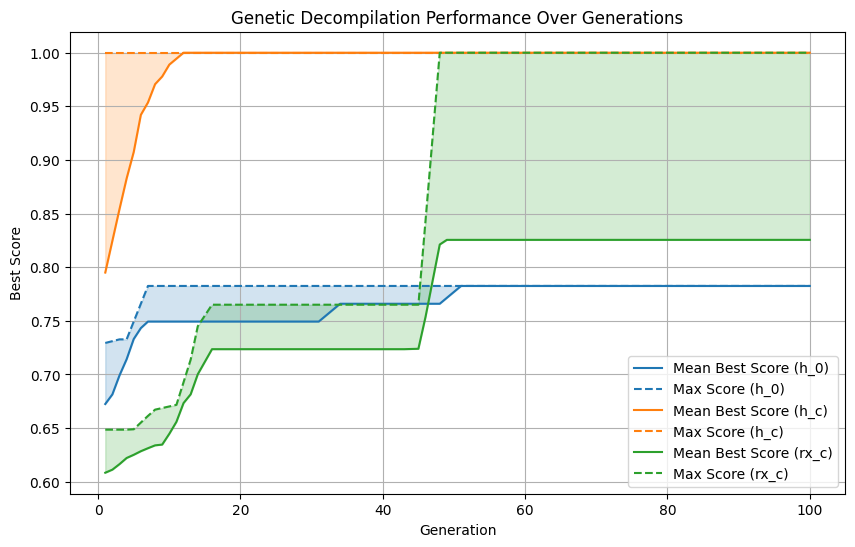

In [ ]:
algorithm = ['h_0', 'h_c', 'rx_c']
plotter = GeneticDecompilationPlotter(algorithm_name='example', algorithms=algorithm)
all_best_scores, all_scores, all_individual = plotter.load_data('simple_test')
# Plot scores and save the figure
plotter.plot_scores(all_best_scores, save_path='Figure/simple_test.png')


In [ ]:

best_codes = []

for _ in algorithm:
    generation_100_scores = [experiment[-1] for experiment in all_best_scores[_]]
    max_score = max(generation_100_scores)
    max_score_index = generation_100_scores.index(max_score)
    print(f"The highest score of {_} in the 100th generation is {max_score}, achieved in experiment {max_score_index + 1}.")
    best_code = all_individual[_][max_score_index][-1]
    print(f'The best code for {_} is {best_code}')
    best_codes.append(best_code)

# 并排输出所有 best_code
print("\nThe best codes for all algorithms are:")
for i, _ in enumerate(algorithm):
    print(f"{_}: {best_codes[i]}")


The highest score of h_0 in the 100th generation is 0.782523380894983, achieved in experiment 1.
The best code for h_0 is def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    for i0 in range(n):
        qc.h((n + 1 - 1) % n)
    return qc
The highest score of h_c in the 100th generation is 1.0, achieved in experiment 1.
The best code for h_c is def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    for i0 in range(n):
        qc.h((i0 + 0 + 0) % n)
    return qc
The highest score of rx_c in the 100th generation is 1.0, achieved in experiment 3.
The best code for rx_c is def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    for i0 in range(n):
        qc.rx(pi * (1 / (2 ** (i0 + 0 - 0) + (n - n - 0 + 0))), (i0 - n + 0 - n + 0) % n)
    return qc

The best codes for all algorithms are:
h_0: def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    for i0 in range(n):
        qc.h((n + 1 - 1) % n)
    return qc
h_c: def generate_random_circu

In [31]:
algorithm = ['qft_decom', 'qpe_dec', 'ghz_state']
plotter = GeneticDecompilationPlotter (algorithm_name='example', algorithms=algorithm)
all_best_scores, all_scores, all_individual = plotter.load_data('advanced_algo')
best_codes = []

for _ in algorithm:
    generation_100_scores = [experiment[-1] for experiment in all_best_scores[_]]
    max_score = max(generation_100_scores)
    max_score_index = generation_100_scores.index(max_score)
    print(f"The highest score of {_} in the 100th generation is {max_score}, achieved in experiment {max_score_index + 1}.")
    best_code = all_individual[_][max_score_index][-1]
    print(f'The best code for {_} is {best_code}')
    best_codes.append(best_code)

# 并排输出所有 best_code
print("\nThe best codes for all algorithms are:")
for i, _ in enumerate(algorithm):
    print(f"{_}: {best_codes[i]}")


The highest score of qft_decom in the 100th generation is 0.5094656486385746, achieved in experiment 3.
The best code for qft_decom is def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.h((n - n - 0 - 0 - 0) % n)
    for i0 in range(n):
        qc.cp(-(pi * (1 / (2 ** (n - n) + (n - n + 1)))), (n + n + 0 + 0 - 1) % n, (n + 1 - 1 + 0 + 0) % n)
        qc.cp(pi * (1 / (2 ** (n - n + 0) + (i0 + 0 + 0 + 1))), (i0 + 1) % n, (i0 - n + n) % n)
    for i0 in range(n):
        qc.h((i0 + n - 0 + 1 + n) % n)
    qc.swap((n + n - 1 + 0 + 1) % n, (n - 0 - 0 - 1 - n) % n)
    return qc
The highest score of qpe_dec in the 100th generation is 0.26036672189653653, achieved in experiment 2.
The best code for qpe_dec is def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    qc.h((n - 1 + n - 1 - n) % n)
    qc.h((n - 1 + n - 1 - n) % n)
    qc.swap((n + 0) % n, (n - 1) % n)
    qc.h((n - 1 + n - 1 - n) % n)
    qc.h((n - 1 + n - 1 - n) % n)
    qc.h((n - 1 + n - 1 - n) % n

: 

In [ ]:
algorithm = ['qft_decom']
plotter = GeneticDecompilationPlotter(algorithm_name='example', algorithms=algorithm, 
                                    compare_method='combined',pop_size=40, generations=100, rep=3)

# Run experiments
all_best_scores, all_scores, all_individual = plotter.load_data('qft')


In [ ]:
last_generation_scores = [experiment[-1] for experiment in all_best_scores[_]]
max_score = max(last_generation_scores)
max_score_index = last_generation_scores.index(max_score)
print(f"The highest score of{_} in the {len(all_best_scores[_][0])} generation is {max_score}, achieved in experiment {max_score_index + 1}.")
best_code=all_individual[_][max_score_index][-1]
print(best_code)

The highest score ofqft_decom in the 1000 generation is 0.6035544399446137, achieved in experiment 1.
def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    for i0 in range(n):
        for i1 in range(abs(n - i0 - 0)):
            qc.cp(pi * (1 / (2 ** (n + 0 + n - 0) + (i0 - 0 + 0 - n + 0))), (i0 + 1 + 1 + n - 1) % n, (i0 - n - n + n + n) % n)
    qc.h((n - 0 + 1 + n - 1) % n)
    return qc


#### further comparison

In [25]:
def save_file(best_code, algorithm, q_min=11,q_max=21):
    # Set up the base directory for saving QASM files
    base_dir = "test"
    os.makedirs(base_dir, exist_ok=True)

    # Define module imports to prepend to the best_code
    module_code = """
from qiskit import QuantumCircuit
import numpy as np
import random
from math import pi
"""

    # Combine the imports with the best_code
    full_code = module_code + best_code

    # Create a dictionary to store the namespace after exec
    local_namespace = {}

    # Execute the combined code
    exec(full_code, globals(), local_namespace)

    # Generate QASM files for each qubit count and save them in structured directories
    for num_qubits in range(q_min,q_max):
        # Construct the directory path for the current algorithm and qubit number
        algorithm_dir = os.path.join(base_dir, f"{algorithm}_{num_qubits}")

        # Run the function to generate the circuit
        qc = local_namespace['generate_random_circuit_ast'](num_qubits)

        # Get the QASM output from the circuit
        qasm_output = qc.qasm()

        # Define the filename for the QASM file
        qasm_filename = algorithm_dir +'.qasm'
        # Write the QASM output to the file
        with open(qasm_filename, 'w') as file:
            file.write(qasm_output)
        # print(f"Saved QASM to {qasm_filename}")

def compare_generated_with_target(algorithm_name, qubit_range,method):
    score_list = {alg: [] for alg in method}
    # Define paths to the directories containing the generated and target QASM files
    generated_base_dir = "test"
    target_base_dir = "Circuits"
    for item in method:
    # Loop through the specified range of qubits
        for num_qubits in qubit_range:
            # Construct the paths to the generated and target QASM files
            generated_qasm_path = os.path.join(generated_base_dir, f"{algorithm_name}_{num_qubits}.qasm")
            target_qasm_path = os.path.join(target_base_dir, f"{algorithm_name}_{num_qubits}.qasm")

            # Use the compare_qasm function from your genetic decompiler
            decompiler=genetic_Decompiler(algorithm_name=algorithm_name,compare_method=item)
            score = decompiler.compare_qasm(generated_qasm_path, target_qasm_path)
            score_list[item].append(score)
    
    return score_list





In [ ]:
decompiler = genetic_Decompiler(algorithm_name='qft_decom')
operations = decompiler.get_quantum_gates_from_qasm()
decompiler.operations = operations


In [ ]:
decompiler.operations

['cp', 'h', 'swap']

In [ ]:
algorithm_name='ry_c'
num_qubits=12
generated_base_dir = "test"
target_base_dir = "Circuits"
generated_qasm_path = os.path.join(generated_base_dir, f"{algorithm_name}_{num_qubits}.qasm")
target_qasm_path = os.path.join(target_base_dir, f"{algorithm_name}_{num_qubits}.qasm")
decompiler=genetic_Decompiler(algorithm_name=algorithm_name,compare_method='fidelity')
score = decompiler.compare_qasm(generated_qasm_path, target_qasm_path)


In [ ]:

algorithm_name='qft_decom'
num_qubits=20
generated_base_dir = "test"
target_base_dir = "Circuits"
generated_qasm_path = os.path.join(generated_base_dir, f"{algorithm_name}_{num_qubits}.qasm")
target_qasm_path = os.path.join(target_base_dir, f"{algorithm_name}_{num_qubits}.qasm")
def get_gate_frequencies(qasm_file_path):
    with open(qasm_file_path, 'r') as file:
        qasm_str = file.read()
    
    quantum_circuit = QuantumCircuit.from_qasm_str(qasm_str)
    gate_count = {}
    for instruction in quantum_circuit.data:
        gate_name = instruction[0].name
        if gate_name in gate_count:
            gate_count[gate_name] += 1
        else:
            gate_count[gate_name] = 1
    return gate_count

decompiler = genetic_Decompiler(algorithm_name=algorithm_name,compare_method='l_by_l')
decompiler.compare_qasm(generated_qasm_path,target_qasm_path)



0.017937219730941704

In [ ]:
seq1=decompiler.qasm_to_gate_sequence(target_qasm_path)
seq2=decompiler.qasm_to_gate_sequence(generated_qasm_path)
seq1_str = ' '.join([f"{gate[0]}{gate[1]}{[f'{param:.6f}' for param in gate[2]]}" if len(gate) == 3 else f"{gate[0]}{gate[1]}" for gate in seq1])
seq2_str = ' '.join([f"{gate[0]}{gate[1]}{[f'{param:.6f}' for param in gate[2]]}" if len(gate) == 3 else f"{gate[0]}{gate[1]}" for gate in seq2])
max_len = max(len(seq1_str), len(seq2_str))
print(max_len)
print(seq1_str)
print(1 - (Levenshtein.distance(seq1_str, seq2_str) / max_len)**(1/3))

4535
h(0,) cp(1, 0)['1.570796'] cp(2, 0)['0.785398'] cp(3, 0)['0.392699'] cp(4, 0)['0.196350'] cp(5, 0)['0.098175'] cp(6, 0)['0.049087'] cp(7, 0)['0.024544'] cp(8, 0)['0.012272'] cp(9, 0)['0.006136'] cp(10, 0)['0.003068'] cp(11, 0)['0.001534'] cp(12, 0)['0.000767'] cp(13, 0)['0.000383'] cp(14, 0)['0.000192'] cp(15, 0)['0.000096'] cp(16, 0)['0.000048'] cp(17, 0)['0.000024'] cp(18, 0)['0.000012'] cp(19, 0)['0.000006'] h(1,) cp(2, 1)['1.570796'] cp(3, 1)['0.785398'] cp(4, 1)['0.392699'] cp(5, 1)['0.196350'] cp(6, 1)['0.098175'] cp(7, 1)['0.049087'] cp(8, 1)['0.024544'] cp(9, 1)['0.012272'] cp(10, 1)['0.006136'] cp(11, 1)['0.003068'] cp(12, 1)['0.001534'] cp(13, 1)['0.000767'] cp(14, 1)['0.000383'] cp(15, 1)['0.000192'] cp(16, 1)['0.000096'] cp(17, 1)['0.000048'] cp(18, 1)['0.000024'] cp(19, 1)['0.000012'] h(2,) cp(3, 2)['1.570796'] cp(4, 2)['0.785398'] cp(5, 2)['0.392699'] cp(6, 2)['0.196350'] cp(7, 2)['0.098175'] cp(8, 2)['0.049087'] cp(9, 2)['0.024544'] cp(10, 2)['0.012272'] cp(11, 2)['

C:\Users\86991\AppData\Local\Temp\ipykernel_22072\1750046639.py:299: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits = [qubit.index for qubit in instruction[1]]


In [ ]:
qasm_lines = [
    "OPENQASM 2.0;",
    "include \"qelib1.inc\";",
    "qreg q[2];",
    "creg c[2];",
    "h q[0];",
    "cx q[0],q[1];",
    "measure q[0] -> c[0];",
    "measure q[1] -> c[1];",
]

target_qasm_lines = [
    'zhuzhu',
    "OPENQASM 2.0;",
    "include \"qelib1.inc\";",
    "qreg q[2];",
    "creg c[2];",
    "h q[0];",
    "cx q[0],q[1];",
    "measure q[0] -> c[0];",
    "// measure q[1] -> c[1];" , # This line is commented out
     
]


def compare_qasm_lcs(qasm_lines, target_qasm_lines):
    def lcs_length(X, Y):
        m = len(X)
        n = len(Y)
        L = [[0] * (n + 1) for i in range(m + 1)]

        for i in range(m + 1):
            for j in range(n + 1):
                if i == 0 or j == 0:
                    L[i][j] = 0
                elif X[i - 1].strip() == Y[j - 1].strip():
                    L[i][j] = L[i - 1][j - 1] + 1
                else:
                    L[i][j] = max(L[i - 1][j], L[i][j - 1])

        return L[m][n]
    # Calculate the length of the longest common subsequence
    lcs_len = lcs_length(qasm_lines, target_qasm_lines)
    
    # Calculate similarity score based on the length of LCS over the total lines in target_qasm
    score = lcs_len / len(target_qasm_lines) if target_qasm_lines else 0
    return score

score = compare_qasm_lcs(qasm_lines, target_qasm_lines)
print(f"Similarity score: {score}")

Similarity score: 0.7777777777777778


The highest score of qft_decom in the 500 generation is 0.5094656486385746, achieved in experiment 3.


C:\Users\86991\AppData\Local\Temp\ipykernel_12412\2414506021.py:299: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits = [qubit.index for qubit in instruction[1]]


The highest score of ghz_state in the 500 generation is 0.8292899749328746, achieved in experiment 1.


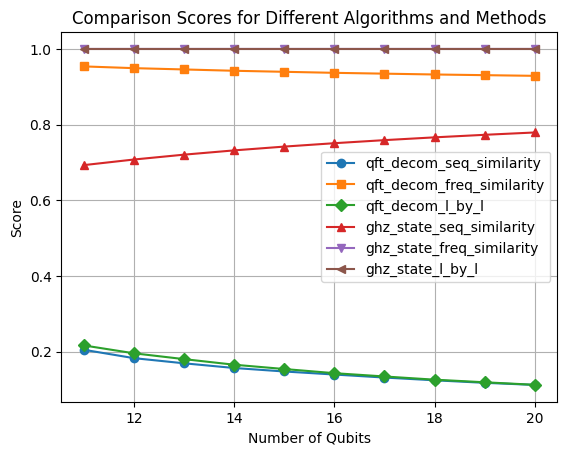

In [27]:
# algorithm = ['ry_decomposed_rx_rz', 'ry_decomposed']
# algorithm = ['h_0', 'h_c', 'rx_c']
# algorithm = ['h_0']
# algorithm = ['ry_c']
# method = ['seq_similarity','freq_similarity','l_by_l']
algorithm = ['qft_decom', 'ghz_state']
method =['seq_similarity','freq_similarity','l_by_l']
plotter = GeneticDecompilationPlotter(algorithm_name='example', algorithms=algorithm)
all_best_scores, all_scores, all_individual = plotter.load_data('advanced_algo')
# Define a dictionary for marker styles
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

for alg_idx, alg in enumerate(algorithm):
    last_generation_scores = [experiment[-1] for experiment in all_best_scores[alg]]
    max_score = max(last_generation_scores)
    max_score_index = last_generation_scores.index(max_score)
    print(f"The highest score of {alg} in the {len(all_best_scores[alg][0])} generation is {max_score}, achieved in experiment {max_score_index + 1}.")
    best_code = all_individual[alg][max_score_index][-1]
    save_file(best_code, alg, q_min=11, q_max=21)
    score_list = compare_generated_with_target(algorithm_name=alg, qubit_range=range(11, 21), method=method)
    for meth_idx, meth in enumerate(method):
        plt.plot(range(11, 21), score_list[meth], label=f'{alg}_{meth}', marker=markers[alg_idx * len(method) + meth_idx])

plt.xlabel('Number of Qubits')
plt.ylabel('Score')
plt.legend()
plt.title('Comparison Scores for Different Algorithms and Methods')
plt.grid(True)
plt.show()
    

In [ ]:
print(all_individual['h_0'][-1][-1])

def generate_random_circuit_ast(n):
    qc = QuantumCircuit(n)
    for i0 in range(n):
        qc.h((n - 0 - 1 + 0 + 1) % n)
    return qc


### Abstract syntax Tree

#### Analyze code

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.rx(pi/2, 1)
print(qc)


     ┌───┐                
q_0: ┤ H ├──■─────────────
     └───┘┌─┴─┐┌─────────┐
q_1: ─────┤ X ├┤ Rx(π/2) ├
          └───┘└─────────┘


#### Create AST Node Definitions

In [ ]:
class Node:
    def evaluate(self):
        raise NotImplementedError("Must be implemented by subclass.")

class QuantumGate(Node):
    def __init__(self, gate_type, qubits, parameters=None):
        self.gate_type = gate_type
        self.qubits = qubits
        self.parameters = parameters

    def evaluate(self):
        param_string = ', '.join(map(str, self.parameters)) if self.parameters else ''
        qubit_string = ', '.join(map(str, self.qubits))
        return f"{self.gate_type}({param_string}) {qubit_string}"

class Circuit(Node):
    def __init__(self):
        self.operations = []

    def add_operation(self, operation):
        self.operations.append(operation)

    def evaluate(self):
        return '\n'.join(op.evaluate() for op in self.operations)

#### Convert Qiskit Circuit to AST

In [ ]:
def qiskit_to_ast(qiskit_circuit):
    ast_circuit = Circuit()
    for instruction, qargs, cargs in qiskit_circuit.data:
        gate_type = instruction.name
        qubits = [q.index for q in qargs]
        parameters = instruction.params
        gate_node = QuantumGate(gate_type, qubits, parameters)
        ast_circuit.add_operation(gate_node)
    return ast_circuit


In [ ]:
from math import pi

# qc = QuantumCircuit(2)
# qc.h(0)
# qc.cx(0, 1)
# qc.rx(pi/2, 1)
qc=qft(4)
ast_circuit = qiskit_to_ast(qc)
print(ast_circuit.evaluate())


QFT() 0, 1, 2, 3
barrier() 0, 1, 2, 3
measure() 0
measure() 1
measure() 2
measure() 3


C:\Users\86991\AppData\Local\Temp\ipykernel_10440\3894827523.py:5: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubits = [q.index for q in qargs]


## Atempt


In [ ]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.quantum_info import Operator

from qiskit import QuantumCircuit

def remove_non_unitary_operations(original_circuit):
    # Create a new quantum circuit with the same number of qubits and classical bits
    new_circuit = QuantumCircuit(original_circuit.num_qubits)
    
    # Iterate over all operations in the original circuit
    for instr, qargs, cargs in original_circuit.data:
        # Check if the operation is unitary (gates are considered unitary)
        if instr.name not in ['measure', 'reset']:
            # If the operation is unitary, add it to the new circuit
            new_circuit.append(instr, qargs, cargs)
    
    return new_circuit


def qasm_to_unitary(circuit):
    
    # Use the Aer's unitary simulator
    simulator = Aer.get_backend('unitary_simulator')
    
    # Transpile the circuit for the simulator
    transpiled_circuit = transpile(circuit, simulator)
    
    # Run the simulation to get the unitary
    job = simulator.run(transpiled_circuit)
    result = job.result()
    
    # Get the unitary matrix from the result
    unitary = result.get_unitary(transpiled_circuit)
    
    return unitary

# Example usage
qasm_path = 'D:/course/thesis/Project2/QCD/Circuits/qft_13.qasm'
original_circuit = QuantumCircuit.from_qasm_file(qasm_path)
unitary_circuit = remove_non_unitary_operations(original_circuit)
unitary_matrix = qasm_to_unitary(unitary_circuit)
print(unitary_matrix)



Operator([[0.01104854+0.00000000e+00j, 0.01104854-1.35305634e-18j,
           0.01104854-1.35305634e-18j, ..., 0.01104854-1.62366761e-17j,
           0.01104854-1.62366761e-17j, 0.01104854-1.75897324e-17j],
          [0.01104854+0.00000000e+00j, 0.01104854+8.47412587e-06j,
           0.01104853+1.69482467e-05j, ..., 0.01104851-2.54223577e-05j,
           0.01104853-1.69482467e-05j, 0.01104854-8.47412587e-06j],
          [0.01104854+0.00000000e+00j, 0.01104853+1.69482467e-05j,
           0.01104849+3.38964536e-05j, ..., 0.01104843-5.08445807e-05j,
           0.01104849-3.38964536e-05j, 0.01104853-1.69482467e-05j],
          ...,
          [0.01104854+0.00000000e+00j, 0.01104851-2.54223577e-05j,
           0.01104843-5.08445807e-05j, ..., 0.01104828+7.62665346e-05j,
           0.01104843+5.08445807e-05j, 0.01104851+2.54223577e-05j],
          [0.01104854+0.00000000e+00j, 0.01104853-1.69482467e-05j,
           0.01104849-3.38964536e-05j, ..., 0.01104843+5.08445807e-05j,
           0.01104

In [ ]:
import pprint
import ast

code = '''
def greet(name):
    print("Hello, " + name + "!")
    
greet("John")
'''

tree = ast.parse(code)
pprint.pprint(ast.dump(tree))

("Module(body=[FunctionDef(name='greet', args=arguments(posonlyargs=[], "
 "args=[arg(arg='name')], kwonlyargs=[], kw_defaults=[], defaults=[]), "
 "body=[Expr(value=Call(func=Name(id='print', ctx=Load()), "
 "args=[BinOp(left=BinOp(left=Constant(value='Hello, '), op=Add(), "
 "right=Name(id='name', ctx=Load())), op=Add(), right=Constant(value='!'))], "
 "keywords=[]))], decorator_list=[]), Expr(value=Call(func=Name(id='greet', "
 "ctx=Load()), args=[Constant(value='John')], keywords=[]))], type_ignores=[])")


In [ ]:
import ast
from graphviz import Digraph

...
# Create a Graphviz Digraph object
dot = Digraph()

# Define a function to recursively add nodes to the Digraph
def add_node(node, parent=None):
    node_name = str(node.__class__.__name__)
    dot.node(str(id(node)), node_name)
    if parent:
        dot.edge(str(id(parent)), str(id(node)))
    for child in ast.iter_child_nodes(node):
        add_node(child, node)

# Add nodes to the Digraph
add_node(tree)

# Render the Digraph as a PNG file
dot.format = 'png'
dot.render('my_ast', view=True)

'my_ast.png'

In [ ]:
import ast
import logging  # Ensure logging is imported if used in the transformed code

class LoggingTransformer(ast.NodeTransformer):
    def visit_FunctionDef(self, node):
        # Check if the function requires logging
        if self.requires_logging(node):
            # Create the logger instance
            logger_stmt = ast.Assign(
                targets=[ast.Name(id='logger', ctx=ast.Store())],
                value=ast.Call(
                    func=ast.Attribute(
                        value=ast.Name(id='logging', ctx=ast.Load()),
                        attr='getLogger',
                        ctx=ast.Load()
                    ),
                    args=[ast.Constant(value=node.name)],
                    keywords=[]
                )
            )
            # Properly set the line number for the new node
            ast.fix_missing_locations(logger_stmt)
            # Insert the logger instance at the beginning of the function body
            node.body.insert(0, logger_stmt)
        return node

    def requires_logging(self, node):
        # Example: add logging based on a simple condition, could be more complex
        return "log" in node.name.lower()

    @staticmethod
    def add_logging(code):
        # Parse the code into an AST
        tree = ast.parse(code)

        # Transform the AST to add logging
        transformer = LoggingTransformer()
        transformed_tree = transformer.visit(tree)
        ast.fix_missing_locations(transformed_tree)

        # Convert the transformed AST back to code
        transformed_code = ast.unparse(transformed_tree)
        return transformed_code

# Example usage:

code = """

def example_function():
    # Function body
    pass

class ExampleClass:
    def __init__(self):
        # Constructor body
        pass

    def example_method(self):
        # Method body
        pass
"""
transformed_code = LoggingTransformer.add_logging(code)
print(transformed_code)
print(ast.dump(ast.parse(code)))

def example_function():
    pass

class ExampleClass:

    def __init__(self):
        pass

    def example_method(self):
        pass
Module(body=[FunctionDef(name='example_function', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Pass()], decorator_list=[]), ClassDef(name='ExampleClass', bases=[], keywords=[], body=[FunctionDef(name='__init__', args=arguments(posonlyargs=[], args=[arg(arg='self')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Pass()], decorator_list=[]), FunctionDef(name='example_method', args=arguments(posonlyargs=[], args=[arg(arg='self')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Pass()], decorator_list=[])], decorator_list=[])], type_ignores=[])


def rx_c(n):
    qc = QuantumCircuit(n)
    angle = pi
    for i in range(n):
        qc.rx(angle, i)
        angle /= 2
    return qc
Module(body=[FunctionDef(name='rx_c', args=arguments(posonlyargs=[], args=[arg(arg='n')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Assign(targets=[Name(id='qc', ctx=Store())], value=Call(func=Name(id='QuantumCircuit', ctx=Load()), args=[Name(id='n', ctx=Load())], keywords=[])), Assign(targets=[Name(id='angle', ctx=Store())], value=Name(id='pi', ctx=Load())), For(target=Name(id='i', ctx=Store()), iter=Call(func=Name(id='range', ctx=Load()), args=[Name(id='n', ctx=Load())], keywords=[]), body=[Expr(value=Call(func=Attribute(value=Name(id='qc', ctx=Load()), attr='rx', ctx=Load()), args=[Name(id='angle', ctx=Load()), Name(id='i', ctx=Load())], keywords=[])), AugAssign(target=Name(id='angle', ctx=Store()), op=Div(), value=Constant(value=2))], orelse=[]), Return(value=Name(id='qc', ctx=Load()))], decorator_list=[])], type_ignores=[])


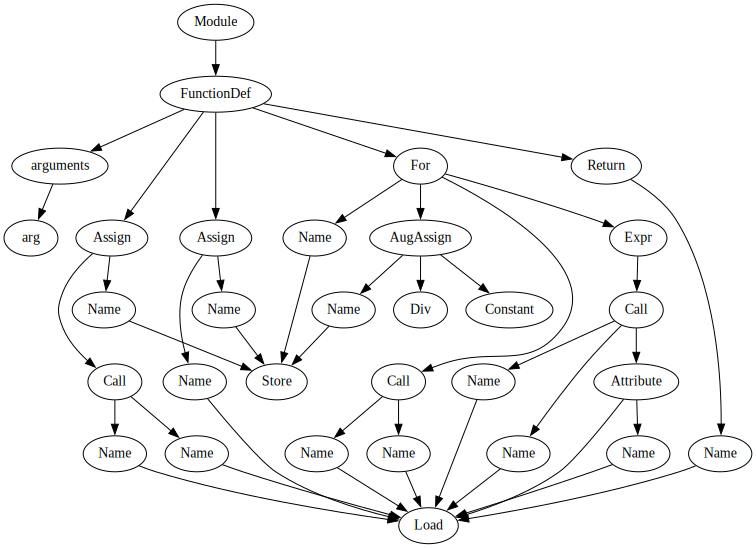

In [ ]:
import ast
from graphviz import Digraph

def show_ast(ast_node, dot=None):
    if dot is None:
        dot = Digraph()
        dot.node(name=str(id(ast_node)), label=type(ast_node).__name__)

    for child in ast.iter_child_nodes(ast_node):
        dot.node(name=str(id(child)), label=type(child).__name__)
        dot.edge(str(id(ast_node)), str(id(child)))
        show_ast(child, dot)

    return dot

code = """
## 
def rx_c(n):
    qc = QuantumCircuit(n)
    angle = pi
    for i in range(n):
        qc.rx(angle, i)
        angle /= 2
    return qc
"""
transformed_code = LoggingTransformer.add_logging(code)
print(transformed_code)
parsed_ast=ast.parse(code)
print(ast.dump(parsed_ast))
show_ast(parsed_ast)


In [ ]:
code
transformed_code = LoggingTransformer.add_logging(code)
print(transformed_code)

def rx_c(n):
    qc = QuantumCircuit(n)
    angle = pi
    for i in range(n):
        qc.rx(angle, i)
        angle /= 2
    return qc


def h_c(n) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)
    return qc
Module(body=[FunctionDef(name='h_c', args=arguments(posonlyargs=[], args=[arg(arg='n')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Assign(targets=[Name(id='qc', ctx=Store())], value=Call(func=Name(id='QuantumCircuit', ctx=Load()), args=[Name(id='n', ctx=Load())], keywords=[])), For(target=Name(id='i', ctx=Store()), iter=Call(func=Name(id='range', ctx=Load()), args=[Name(id='n', ctx=Load())], keywords=[]), body=[Expr(value=Call(func=Attribute(value=Name(id='qc', ctx=Load()), attr='h', ctx=Load()), args=[Name(id='i', ctx=Load())], keywords=[]))], orelse=[]), Return(value=Name(id='qc', ctx=Load()))], decorator_list=[], returns=Name(id='QuantumCircuit', ctx=Load()))], type_ignores=[])


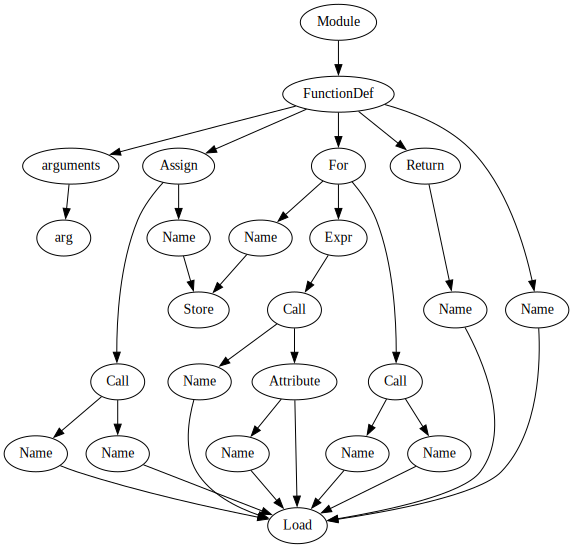

In [ ]:
basecode = """
def h_c(n) -> QuantumCircuit:
    
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)
    return qc
"""

forcode = """
for i in range(0,n):
    x = i
"""

gatecode = """
qc.h(i)
"""

transformed_code = LoggingTransformer.add_logging(basecode)
print(transformed_code)
parsed_ast=ast.parse(basecode)
print(ast.dump(parsed_ast))
show_ast(parsed_ast)

# transformed_code = LoggingTransformer.add_logging(forcode)
# print(transformed_code)
# parsed_ast=ast.parse(forcode)
# print(ast.dump(parsed_ast))
# show_ast(parsed_ast)



##### skeleton code mode